In [2]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [3]:
import os
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.optimization as opt
import biogeme.messaging as message
from biogeme import expressions as ex
import pandas as pd
import numpy as np
import xlsxwriter
from tqdm import tqdm
from quetzal.io import excel

# Calibration
## Estimation of the model parameters
quetzal_germany is being estimated using [PandasBiogeme](https://biogeme.epfl.ch/). This notebook estimates calibration parameters for the model's utility functions.
- Documentation and reference: [Bierlaire, M. (2020). A short introduction to PandasBiogeme. Technical report TRANSP-OR 200605. Transport and Mobility Laboratory, ENAC, EPFL.](https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf)
- Tutorial: https://www.youtube.com/watch?v=OiM94B8WayA

### Model formulation

The joint generation and distribution model makes distance classes in destination choice obsolete. It accounts for each possible destination zone plus a stay option (not making any trip).

$V_i^{zone} = V_{i,m}^{mode} + log(\sum_{j\in A} \beta_j a_{i,j}) + \beta_{TOUR} a_{i,TOUR}$

with $\beta_1=1$. Zone-specific attraction attributes are covered in theory in Daly (1982; DOI: 10.1016/0191-2615(82)90037-6):

$A = \text{\{D_POP, D_EMPL, D_SHOP, D_EDU, D_LEISURE, D_TOURISM\}}$

In the choice tree, each zone has a nest of modes to reach it. In case of sequential estimation, results of the mode tier become aggregated with the formula of generalised cost. The mode choice model consists of systematic utility functions, one for each mode in the choice set. They comprise an alternaive-specific constant (ASC), a distance-dependent part with travel time and cost summarised as generalised cost (GC), and a cost damping function F

$V_{i,m}^{mode} = ASC_{i,m} + F(GC(T_m, C_m)_i, b_{gc_i})$

Index i marks the demand group. I = {'commuting' (1), 'education' (2), 'shopping/medical' (3), 'business' (4), 'private' (6)} x {'no_car' (0), 'car_owned' (1)}

Note: The cost variable already includes subscriptions

In [4]:
input_path = '../input/'
model_path = '../model/'
output_path = '../output/'

In [5]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

### Prepare the database

In [6]:
df = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv')
df = df[['cost_rail_short', 'cost_rail_long', 'cost_car', 'cost_coach', 'cost_bus', 'cost_walk', 'cost_air',
         'time_rail_short', 'time_rail_long', 'time_car', 'time_coach', 'time_bus', 'time_walk', 'time_air',
         'cost_rail', 'cost_road', 'time_rail', 'time_road',
         'mode_model', 'purpose_model', 'purpose2', 'car_avail', 'distance', 'origin', 'destination', 'P_ID', 'W_GEW',
         'dest_urban', 'dest_pop', 'dest_employment', 'dest_tourism', 'dest_area',
         'dest_shopping_many', 'dest_shopping_few', 'dest_education_many', 'dest_education_few',
         'dest_leisure_many', 'dest_leisure_few', 'dest_accompany']]
df.columns = ['C_RAIL_S', 'C_RAIL_L', 'C_CAR', 'C_COACH', 'C_BUS', 'C_NON_MOTOR', 'C_AIR',
              'T_RAIL_S', 'T_RAIL_L', 'T_CAR', 'T_COACH', 'T_BUS', 'T_NON_MOTOR', 'T_AIR',
              'C_RAIL', 'C_ROAD', 'T_RAIL', 'T_ROAD',
              'MODE', 'PURPOSE', 'P2', 'CAR_AV', 'DIST', 'O', 'D', 'P_ID', 'W_GEW',
              'D_URBAN', 'D_POP', 'D_EMPL', 'D_TOURISM', 'D_AREA',
              'D_SHOP-MANY', 'D_SHOP-FEW', 'D_EDU-MANY', 'D_EDU-FEW',
              'D_LEISURE-MANY', 'D_LEISURE-FEW', 'D_ACCOM']

In [7]:
# Drop return trips
df = df.loc[~df['P2'].isin([8,9])]
len(df)

155235

In [8]:
# The estimation requires numerical purpose values
p_model_dict = {'commuting':1, 'business':2, 'education':3,
                'buy/execute':4, 'leisure':6, 'accompany':7}
df['PURPOSE'] = df['PURPOSE'].apply(lambda s: p_model_dict[s.split('_')[0]])

In [9]:
inf = 10000
df = df.replace({np.inf:inf})

In [10]:
# Scale population and employment
df['D_POP_S'] = df['D_POP'] / 1e6
df['D_EMPL_S'] = df['D_EMPL'] / 1e6
df['D_POP_S'].mean()

0.3631540267401566

In [11]:
# Scale POIs to the same level as population
df['D_SHOP-FEW_S'] = df['D_SHOP-FEW'] / 100
df['D_EDU-FEW_S'] = df['D_EDU-FEW'] / 100
df['D_LEISURE-FEW_S'] = df['D_LEISURE-FEW'] / 100
df['D_SHOP-MANY_S'] = df['D_SHOP-MANY'] / 1000
df['D_EDU-MANY_S'] = df['D_EDU-MANY'] / 1000
df['D_LEISURE-MANY_S'] = df['D_LEISURE-MANY'] / 1000
df['D_ACCOM_S'] = df['D_ACCOM'] / 1000

In [12]:
# Make car availability binary
df['CAR_AV'] = df['CAR_AV'].replace({9:0})

In [13]:
# Add PT availabilities
df['RAIL_AV'] = (df['T_RAIL']!=inf).astype(int)
df['RAIL_S_AV'] = (df['T_RAIL_S']!=inf).astype(int)
df['RAIL_L_AV'] = (df['T_RAIL_L']!=inf).astype(int)
df['COACH_AV'] = (df['T_COACH']!=inf).astype(int)
df['BUS_AV'] = (df['T_BUS']!=inf).astype(int)
df['ROAD_AV'] = (df['T_ROAD']!=inf).astype(int)
df['AIR_AV'] = (df['T_AIR']!=inf).astype(int)
df['NON_MOTOR_AV'] = (df['DIST']<100).astype(int)

In [14]:
df['MODE'] = df['MODE'].replace({2:1, 3:4})

In [15]:
# Hash origin and destination columns (integer)
zone_set = set(df['D']).union(set(df['O']))
zone_dict = dict(zip(zone_set, range(len(zone_set))))
df['O'] = df['O'].map(zone_dict).astype(int)
df['D'] = df['D'].map(zone_dict).astype(int)

### Distance classes

Destination choice does not work for a large set of choice options, such as 400 zones. Thus, the individual choice sets are limited to various distance classes, which are consistent with the stay/go and distance choice model.

In [16]:
# Clean distances
df = df.loc[df['DIST']<=1000]
df['DIST'] = df['DIST'].astype(int)
len(df)

155235

In [17]:
# Remove STAY rows for estimation without gneration
if 'STAY' in zone_dict.keys():
    df = df.loc[df['D']!=zone_dict['STAY']]
    print(len(df))
else:
    zone_dict['STAY'] = len(zone_set)+1
    stay_mask = df['MODE']!=999

In [18]:
# Classify into distance bins
bins = [-1, 60, 150, 1000]
df['DIST_bin'] = pd.cut(df['DIST'], bins=bins, labels=bins[1:]).astype(int)

In [19]:
# Create a bin for STAY observations and inner-zonal trips
df.loc[df['D']==zone_dict['STAY'], 'DIST_bin'] = 0
df.loc[df['D']==df['O'], 'DIST_bin'] = 1
df.groupby('DIST_bin').count()['O']#.plot.pie()

DIST_bin
1       101174
60       47749
150       3966
1000      2346
Name: O, dtype: int64

In [20]:
# Trip is inner- or inter-zonal?
df['GO'] = df['DIST_bin'].clip(lower=0, upper=2).astype(int)

### Model variables
All columns are variables. DefineVariable creates a new column in the database.

#### Cost damping

Many modelling studies have shown that cost damping is required in order to flatten the tail of time/cost elasticities, i.e. decrease the impact of long distances on choice results to prevent from overestimation of time/cost parameters. Cost damping represents the property of decreasing marginal utility. It is commonly approached with Box-Cox transformations of generalised cost (usually defined as the sum of travel time and travel expenditures divided by the value of time). Daly (2010) proposes a hybrid function as a sum of the linear term and the narural logarithm of the same. However, the linear term still dominates cost on long distances. Rich (2015), main developer of the Danish National Transport Model, proposes a more complex spline function which successfully manages cost damping and even outperforms the Box-Cox transformation in terms of stability of elasticities.

In [21]:
# The cost damping function from Rich (2020)
c = params['estimation']
def spline(x, beta, c1, c2, Q=3):
    alpha = [0, -beta/2*ex.Power(ex.log(c1),3),
             -beta/2*ex.log(c1)*(3*ex.Power(ex.log(c2),2)+ex.Power(ex.log(c1),2))] # for Q=3
    theta = [1, 3/2*ex.log(c1), 3*ex.log(c1)*ex.log(c2)] # for Q=3
    return (beta*theta[0]*ex.Power(ex.log(x),Q-1+1) + alpha[0]) * (x<c1) \
    + (beta*theta[1]*ex.Power(ex.log(x),Q-2+1) + alpha[1]) * (x>=c1)*(x<c2) \
    + (beta*theta[2]*ex.Power(ex.log(x),Q-3+1) + alpha[2]) * (x>=c2)

#### Generalised cost

Both, travel time and monetary cost should be affected by cost damping measures. It is logical to define a generalised cost term `GC` with dimension of time units. This requires definition or estimation of values of time, in order to rescale monetary units, for all segments. Usually, the value of time (VoT) is distance-dependent. In the case of Germany, VoT can be taken from research undertaken within the Federal Government's transport study "Bundesverkehrswegeplan 2030": Axhausen et al. 2015. Ermittlung von Bewertungsansätzen für Reisezeiten und Zuverlässigkeit auf der Basis eines Modells für modale Verlagerungen im nicht-gewerblichen und gewerblichen Personenverkehr für die Bundesverkehrswegeplanung

In [22]:
# Load VoT for GC calculation
vot = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0).to_dict()

In [23]:
# Translation of purposes (MiD2017 to VP2030)
p_dict = {1:'Fz1', 3:'Fz2', 4:'Fz3', 2:'Fz4', 6:'Fz6', 7:'Fz6'}

In [24]:
# define the GC function
car_vot_descr = ['PT', 'all'] # for indexing with car=[0,1]
def GC(time, price, p, car, dist):
    return time + (price / vot[(p, car_vot_descr[car])][dist])

#### Utility

The database should have columns with prices and travel times for each mode of the trip which can be used to calculate utilities of mode choice, given the estimated beta parameters from the mode choice step.

In [25]:
# Load mode choice parameters
beta_time = {} # time in minutes
beta_price = {}
excel = pd.ExcelFile(input_path + 'estimation_results.xls')
p_dict_model = {1:'commuting', 2:'business', 3:'education', 4:'buy/execute', 6:'leisure', 7:'accompany'}
for p, p_str in p_dict_model.items():
    beta_time[p] = {}
    beta_price[p] = {}
    for car, car_str in {1:'_car', 0:'_no_car'}.items():
        params_est = excel.parse(p_str.replace('/', '-')+car_str, index_col=0)
        beta_time[p][car] = params_est.loc['b_t', 'Value']
        try:
            beta_price[p][car] = params_est.loc['b_c', 'Value']
        except KeyError:
            beta_price[p][car] = 0

In [26]:
# Function to get utility of travel time
def time_ut(time, p, car):
    # Given time in minutes and the segment (purpose, car)
    #return spline(time, beta_time[p][car], c['c1_time_'+str(p_dict[p][-1])]*60, c['c2_time_'+str(p_dict[p][-1])]*60)
    # The fist part of the spline is a log-power
    return np.power(np.log(time), 3) * beta_time[p][car]

In [27]:
# Function to get utility of price
def price_ut(price, p, car):
    # Given the price and the segment (purpose, car)
    return price * beta_price[p][car]

#### Composite cost / logsum
In a sequential estimation process, it is required to aggregate all variables of the upper decision level and insert them in this decision level. Using the formula from Walker (1977) - see formula 6.10 in Ortúzar and Willumsen (2011) p. 213 - we can assume that the perception of alternatives is depicted properly.

In [28]:
# Load inter-zonal composite cost from mode choice step
cc = pd.read_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv')
# Map to integer zone names and drop unused pairs
cc['origin'] = cc['origin'].map(zone_dict)
cc['destination'] = cc['destination'].map(zone_dict)
cc = cc.loc[(cc['origin'].notna()) & (cc['destination'].notna())]
cc['origin'] = cc['origin'].astype(int)
cc['destination'] = cc['destination'].astype(int)
cc.set_index(['origin', 'destination'], inplace=True)
cc.index.names = ['O', 'D']
# Rename segments to integer values
cc.columns = pd.MultiIndex.from_tuples(
    [(p_model_dict[seg.split('_')[0]], {'no': 0, 'car': 1}[seg.split('_')[1]])
     for seg in cc.columns],
    names=['PURPOSE', 'CAR_AV'])
# Reshape the table into a mergable format
cc = cc.unstack('D').stack('PURPOSE').stack('CAR_AV')
cc.columns = ['CC_'+str(zone) for zone in cc.columns]

In [29]:
# Inter-zonal CC
df = df.merge(cc, how='left', left_on=['O', 'PURPOSE', 'CAR_AV'], right_index=True)

In [30]:
# Inner-zonal
for d in tqdm(list(zone_dict.values())):
    mask = df['O']!=d
    car_av_s = df.loc[~mask, 'CAR_AV']
    p_s = df.loc[~mask, 'PURPOSE']
    t_rail_s = pd.Series([time_ut(t, p, car) if t!=inf else np.nan
                          for t,p,car in zip(df.loc[~mask, 'T_RAIL'], p_s, car_av_s)],
                         dtype=float)
    t_bus_s = pd.Series([time_ut(t, p, car) if t!=inf else np.nan
                         for t,p,car in zip(df.loc[~mask, 'T_BUS'], p_s, car_av_s)],
                         dtype=float)
    t_car_s = pd.Series([time_ut(t, p, car) if car==1 else np.nan
                         for t,p,car in zip(df.loc[~mask, 'T_CAR'], p_s, car_av_s)],
                         dtype=float)
    t_non_s = pd.Series([time_ut(t, p, car) if t!=inf else np.nan
                         for t,p,car in zip(df.loc[~mask, 'T_NON_MOTOR'], p_s, car_av_s)],
                         dtype=float)
    p_rail_s = pd.Series([price_ut(t, p, car) if t!=inf else np.nan
                          for t,p,car in zip(df.loc[~mask, 'C_RAIL'], p_s, car_av_s)],
                         dtype=float)
    p_bus_s = pd.Series([price_ut(t, p, car) if t!=inf else np.nan
                         for t,p,car in zip(df.loc[~mask, 'C_BUS'], p_s, car_av_s)],
                         dtype=float)
    p_car_s = pd.Series([price_ut(t, p, car) if car==1 else np.nan
                         for t,p,car in zip(df.loc[~mask, 'C_CAR'], p_s, car_av_s)],
                         dtype=float)
    # Calculate the logsum
    df.loc[~mask, 'CC_'+str(d)] = [np.log(np.maximum(4, np.sum(
        pd.Series([np.exp(-1*(t_rail+p_rail)),
                   np.exp(-1*(t_bus+p_bus)),
                   np.exp(-1*(t_car+p_car)),
                   np.exp(-1*t_non)]))))
                                   for t_rail, t_bus, t_car, t_non, p_rail, p_bus, p_car
                                   in zip(t_rail_s, t_bus_s, t_car_s, t_non_s,
                                          p_rail_s, p_bus_s, p_car_s)]

100%|██████████████████████████████████████████████████████████████████████████████| 1933/1933 [00:46<00:00, 41.54it/s]


In [31]:
# Fill NaN values with segment's max values
for p in df['PURPOSE'].unique():
    for car in df['CAR_AV'].unique():
        mask = (df['PURPOSE']==p) & (df['CAR_AV']==car), [c for c in df.columns if c[:2]=='CC']
        df.loc[mask] = df.loc[mask].fillna(
            cc.xs(p, level='PURPOSE').xs(car, level='CAR_AV').max().max())

In [32]:
# All CC must be greater 0
assert df[[c for c in df.columns if c.startswith('CC_')]].min().min() > 0

In [33]:
# Calculate the accessibility of the origin zone
# Use the logsum formula with CC from all other zones
#df['ACC'] = np.log(np.sum(np.exp(df[[c for c in df.columns if c.startswith('CC_')]]), axis=1))
df['ACC'] = df[[c for c in df.columns if c.startswith('CC_')]].mean(axis=1)

<AxesSubplot:>

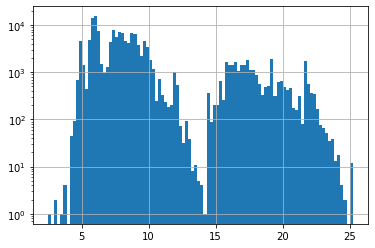

In [34]:
df['ACC'].hist(bins=100, log=True)

In [35]:
# Add distances to the attributes
# in case CC does not suffice as distance measure
dist = pd.read_csv(output_path + 'distances_centroids.csv') # km
dist = dist.loc[(dist['origin'].map(zone_dict).notna())
                & (dist['destination'].map(zone_dict).notna())]
dist['origin'] = dist['origin'].map(zone_dict).astype(int)
dist['destination'] = dist['destination'].map(zone_dict).astype(int)
dist.set_index(['origin', 'destination'], inplace=True)
dist = dist.unstack('destination').fillna(0).droplevel(0, axis=1)
df = df.merge(dist, how='left', left_on='O', right_index=True)
df.rename(columns={z: 'DIST_'+str(z) for z in df['D'].unique()}, inplace=True)
df = df.loc[df.notna().all(axis=1)]
len(df)

155221

In [124]:
# Get the relation between CC and distance for every segment
cc_dist_rel = {}
for p in df['PURPOSE'].unique():
    cc_dist_rel[p] = {}
    for car in df['CAR_AV'].unique():
        cc_dist_rel[p][car] = {}
        # Merge CC and OD distance data
        cc_stack = cc.xs(p, level='PURPOSE').xs(car, level='CAR_AV').rename(
            columns={c: int(c.split('_')[1]) for c in cc.columns}).stack().dropna()
        cc_stack.index.names = ['origin', 'destination']
        cc_stack.name = 'CC'
        merged = pd.DataFrame(cc_stack).merge(dist.stack().rename('dist'),
                                              left_index=True, right_index=True, how='inner')
        merged = merged.loc[merged['dist']>0]
        
        # Calculate metrics
        cc_dist_rel[p][car]['corr'] = merged.corr().loc['dist', 'CC']
        coef = np.polyfit(x=merged['dist'], y=merged['CC'], deg=1)
        cc_dist_rel[p][car]['intercept'] = coef[1]
        cc_dist_rel[p][car]['slope'] = coef[0]
cc_dist_rel

{4: {1: {'corr': 0.7794627162719312,
   'intercept': 3.265452523250122,
   'slope': 0.011613001557131047},
  0: {'corr': 0.9235468536649263,
   'intercept': 5.657561806685959,
   'slope': 0.005701226399690235}},
 6: {1: {'corr': 0.6139636537095833,
   'intercept': 4.597298197996851,
   'slope': 0.0030793685683175556},
  0: {'corr': 0.5729661612474145,
   'intercept': 5.13942318832389,
   'slope': 0.0020149513324241156}},
 7: {1: {'corr': 0.7441952840178291,
   'intercept': 3.658799455742527,
   'slope': 0.014463195082016702},
  0: {'corr': 0.9974676141641019,
   'intercept': 2.9146235298113474,
   'slope': 0.026725078510779394}},
 1: {1: {'corr': 0.8306084851469295,
   'intercept': 5.304996045617766,
   'slope': 0.03083701740307867},
  0: {'corr': 0.937747044470295,
   'intercept': 4.165893167542781,
   'slope': 0.0062200467131824}},
 3: {1: {'corr': 0.7303300496267939,
   'intercept': 6.096832132861296,
   'slope': 0.007339966675576075},
  0: {'corr': 0.9832840955475266,
   'intercept

#### Zone attraction

As for modes, every observation needs attraction attributes for all zones available.

In [36]:
# Generate zone-specific variables for every attribute
for attr in ['D_URBAN', 'D_POP', 'D_EMPL', 'D_AREA'#,
             #'D_SHOP-MANY', 'D_EDU-MANY', 'D_LEISURE-MANY',
             #'D_SHOP-FEW', 'D_EDU-FEW', 'D_LEISURE-FEW', 'D_ACCOM'
             #'D_SHOP-MANY_S', 'D_EDU-MANY_S', 'D_LEISURE-MANY_S',
             #'D_SHOP-FEW_S', 'D_EDU-FEW_S', 'D_LEISURE-FEW_S', 'D_ACCOM_S'
            ]:
    attr_dict = df.set_index('D')[attr].to_dict()
    for zone, value in attr_dict.items():
        globals()[attr.split('_')[1] + '_' + str(zone)] = value
    globals()[attr.split('_')[1] + '_' + str(zone_dict['STAY'])] = 0
    df[attr.replace('D_', 'O_').replace('-', '_')] = df['O'].map(attr_dict).fillna(0)

In [37]:
df['O_AREA'] += 1

In [38]:
# Generate categories of OSM POIs
cats = pd.read_excel(input_path + 'spatial_OSM_POI_list.xlsx', sheet_name='categories')
pois = pd.read_csv(input_path + 'spatial_num_pois_raw.csv', index_col='index')
cats['label'] = (cats['key'] + ' ' + cats['value'].fillna('')).str.strip()
col_dict = cats.loc[cats['category'].notna()
                   ].groupby('category').agg({'label': list}).to_dict()['label']
for category, columns in col_dict.items():
    for zone, value in pois[columns].sum(axis=1).items():
        if zone in zone_dict.keys():
            globals()[category.upper() + '_' + str(zone_dict[zone])] = value
    globals()[category.upper() + '_' + str(zone_dict['STAY'])] = 0
    df['O_'+category.upper()] = df['O'].map(attr_dict).fillna(0)
    print(category.upper())

CHILDCARE
DAILY_LEISURE
HIGHER_EDUCATION
HOLIDAY
MEDICAL
OCCASIONAL_LEISURE
SCHOOL
SHOP
SPECIAL_SHOP


### Create database

This makes all columns become global variables.

In [39]:
# Create the initial database and make columns global variables
database = db.Database('MiD2017', df.copy())
globals().update(database.variables)
database.getSampleSize()

155221

### Estimation parameters

In [40]:
# Destination choice / attraction
b_urban = ex.Beta('b_urban', 0, None, None, 0)
b_pop = ex.Beta('b_pop', 0, None, None, 0)
b_empl = ex.Beta('b_empl', 0.1, 0, None, 0)
b_shop1 = ex.Beta('b_shop1', 0.1, 0, None, 0)
b_edu1 = ex.Beta('b_edu1', 0.1, 0, None, 0)
b_leisure1 = ex.Beta('b_leisure1', 0.1, 0, None, 0)
b_accom1 = ex.Beta('b_accom1', 0.1, 0, None, 0)
b_shop2 = ex.Beta('b_shop2', 0.1, 0, None, 0)
b_edu2 = ex.Beta('b_edu2', 0.1, 0, None, 0)
b_leisure2 = ex.Beta('b_leisure2', 0.1, 0, None, 0)
b_accom2 = ex.Beta('b_accom2', 0.1, 0, None, 0)
b_shop3 = ex.Beta('b_shop3', 0.1, 0, None, 0)
b_edu3 = ex.Beta('b_edu3', 0.1, 0, None, 0)
b_leisure3 = ex.Beta('b_leisure3', 0.1, 0, None, 0)
b_accom3 = ex.Beta('b_accom3', 0.1, 0, None, 0)
b_local = ex.Beta('b_local', 0, None, None, 0)
b_area = ex.Beta('b_area', 0, None, None, 0)

In [41]:
# Beta parameter for size variables, following Daly 1982
b_size = ex.Beta('b_size', 0, 0, 1, 0)

In [42]:
# generalised cost function / mode choice utility parameter
b_gc = ex.Beta('b_gc', -0.1, None, 0, 0)
# Distance parameter
b_dist = ex.Beta('b_dist', -0.1, None, 0, 0)
b_dist2 = ex.Beta('b_dist2', -0.1, None, None, 0)

In [43]:
# Logsum parameters
phi = ex.Beta('phi', 0.5, 0, 1, 0)

In [44]:
# Parameters for nests
mu_go = ex.Beta('mu_go', 1, 1, 10, 0)
mu_u1 = ex.Beta('mu_u1', 1, 1, 10, 0)
mu_u2 = ex.Beta('mu_u2', 1, 1, 10, 0)
mu_u3 = ex.Beta('mu_u3', 1, 1, 10, 0)

In [45]:
# ASC for stay/go choice
asc_stay = ex.Beta('asc_stay', 0, None, None, 0)
asc_inner = ex.Beta('asc_inner', 0, None, None, 0)
asc_inter = ex.Beta('asc_inter', 0, None, None, 0)

### Utility functions

In [46]:
# Destination choice utility by segment
# using the sum of variables of size in a logarithm
# Daly3
V_D = {}
for p in df['PURPOSE'].unique():
    V_D[p] = {}
for car in df['CAR_AV'].unique():
    # Commuting
    V_D[1][car] = {zone: ex.log(globals()['EMPL_'+str(zone)]) * b_size
           + ex.log((1 + globals()['POP_'+str(zone)]) / globals()['AREA_'+str(zone)]) * b_pop
           #+ globals()['URBAN_'+str(zone)] * b_urban
           + globals()['CC_'+str(zone)] * b_gc
           + globals()['DIST_'+str(zone)] * b_dist
           for zone in df['D'].unique()}
    ## Business
    V_D[2][car] = {zone: ex.log(globals()['EMPL_'+str(zone)]) * b_size
           + ex.log((1 + globals()['POP_'+str(zone)]) / globals()['AREA_'+str(zone)]) * b_pop
           + globals()['URBAN_'+str(zone)] * b_urban
           + globals()['CC_'+str(zone)] * b_gc
           + globals()['DIST_'+str(zone)] * b_dist
           for zone in df['D'].unique()}
    # Education
    V_D[3][car] = {zone: ex.log(1 + globals()['CHILDCARE_'+str(zone)] * ex.exp(b_edu1)
                                + globals()['SCHOOL_'+str(zone)] * ex.exp(b_edu2)
                                + globals()['HIGHER_EDUCATION_'+str(zone)]
                               ) * b_size
           + ex.log((1 + globals()['POP_'+str(zone)] )/ globals()['AREA_'+str(zone)]) * b_pop
           #+ globals()['URBAN_'+str(zone)] * b_urban
           + globals()['CC_'+str(zone)] * b_gc
           + globals()['DIST_'+str(zone)] * b_dist
           for zone in df['D'].unique()}
    # Shopping
    V_D[4][car] = {zone: ex.log(1 + globals()['SHOP_'+str(zone)] * ex.exp(b_shop1)
                                + globals()['MEDICAL_'+str(zone)] * ex.exp(b_shop2)
                                + globals()['SPECIAL_SHOP_'+str(zone)]
                               ) * b_size
           + ex.log((1 + globals()['POP_'+str(zone)]) / globals()['AREA_'+str(zone)]) * b_pop
           #+ globals()['URBAN_'+str(zone)] * b_urban
           + globals()['CC_'+str(zone)] * b_gc
           + globals()['DIST_'+str(zone)] * b_dist
           for zone in df['D'].unique()}
    # Leisure
    V_D[6][car] = {zone: ex.log(1 + globals()['DAILY_LEISURE_'+str(zone)] * ex.exp(b_leisure1)
                                + globals()['HOLIDAY_'+str(zone)] * ex.exp(b_leisure2)
                                + globals()['OCCASIONAL_LEISURE_'+str(zone)]
                               ) * b_size
           + ex.log((1 + globals()['POP_'+str(zone)]) / globals()['AREA_'+str(zone)]) * b_pop
           + globals()['URBAN_'+str(zone)] * b_urban
           + globals()['CC_'+str(zone)] * b_gc
           + globals()['DIST_'+str(zone)] * b_dist
           + globals()['DIST_'+str(zone)] * globals()['DIST_'+str(zone)] * b_dist2 * int(car>0)
           for zone in df['D'].unique()}
    # Accompany
    V_D[7][car] = {zone: ex.log(1 + globals()['MEDICAL_'+str(zone)] * ex.exp(b_accom1)
                                + globals()['SCHOOL_'+str(zone)] * ex.exp(b_accom2)
                                + globals()['CHILDCARE_'+str(zone)]
                               ) * b_size
           + ex.log((1 + globals()['POP_'+str(zone)]) / globals()['AREA_'+str(zone)]) * b_pop
           #+ globals()['URBAN_'+str(zone)] * b_urban
           + globals()['CC_'+str(zone)] * b_gc
           + globals()['DIST_'+str(zone)] * b_dist
           + globals()['DIST_'+str(zone)] * globals()['DIST_'+str(zone)] * b_dist2
           for zone in df['D'].unique()}

# The utility for STAY is zero
for p in V_D.keys():
    for car in [0,1]:
        V_D[p][car][zone_dict['STAY']] = 0 #asc_stay

In [47]:
# The utility for STAY/inner/inter
V_GO = {}
for p in df['PURPOSE'].unique():
    V_GO[p] = {car: {} for car in df['CAR_AV'].unique()}
    for car in df['CAR_AV'].unique():
        V_GO[p][car][0] = 0 #asc_stay
        V_GO[p][car][2] = asc_inter + ACC * b_gc

# Utility for inner-zonal travel depends on zone POIs
b_size = ex.Beta('b_size', 0, 0, None, 0)

for car in df['CAR_AV'].unique():
    # Commuting
    V_GO[1][car][1] = ex.log(1 + O_EMPL) * b_size \
           + ex.log((1 + O_POP) / O_AREA) * b_pop + O_URBAN * b_urban
    ## Business
    V_GO[2][car][1] = ex.log(1 + O_EMPL) * b_size \
           + ex.log((1 + O_POP) / O_AREA) * b_pop + O_URBAN * b_urban
    # Education
    V_GO[3][car][1] = ex.log(1 + O_CHILDCARE# * ex.exp(b_edu1)
                             + O_SCHOOL# * ex.exp(b_edu2)
                             + O_HIGHER_EDUCATION
                            ) * b_size \
           + ex.log((1 + O_POP) / O_AREA) * b_pop + O_URBAN * b_urban
    # Shopping
    V_GO[4][car][1] = ex.log(1 + O_SHOP# * ex.exp(b_shop1)
                             + O_MEDICAL# * ex.exp(b_shop2)
                             + O_SPECIAL_SHOP
                            ) * b_size \
           + ex.log((1 + O_POP) / O_AREA) * b_pop + O_URBAN * b_urban
    # Leisure
    V_GO[6][car][1] = ex.log(1 + O_DAILY_LEISURE# * ex.exp(b_leisure1)
                             + O_HOLIDAY# * ex.exp(b_leisure2)
                             + O_OCCASIONAL_LEISURE
                            ) * b_size \
           + ex.log(1 + O_POP / O_AREA) * b_pop + O_URBAN * b_urban
    # Accompany
    V_GO[7][car][1] = ex.log(1 + O_MEDICAL# * ex.exp(b_accom1)
                             + O_SCHOOL# * ex.exp(b_accom2)
                             + O_CHILDCARE
                            ) * b_size \
           + ex.log(1 + O_POP / O_AREA) * b_pop + O_URBAN * b_urban

In [125]:
# The utility for STAY/inner/inter
V_GO = {}
for p in df['PURPOSE'].unique():
    V_GO[p] = {car: {} for car in df['CAR_AV'].unique()}
    for car in df['CAR_AV'].unique():
        V_GO[p][car][0] = 0 #asc_stay
        V_GO[p][car][2] = asc_inter + ACC * b_gc

# Utility for inner-zonal travel depends on zone POIs
b_size = ex.Beta('b_size', 0, 0, None, 0)

for car in df['CAR_AV'].unique():
    # Commuting
    V_GO[1][car][1] = ex.log(1 + O_EMPL) * b_size \
           + ex.Power(O_AREA, 0.5) * b_gc * cc_dist_rel[1][car]['slope']# + O_URBAN * b_urban
    ## Business
    V_GO[2][car][1] = ex.log(1 + O_EMPL) * b_size \
           + ex.Power(O_AREA, 0.5) * b_gc * cc_dist_rel[2][car]['slope']# + O_URBAN * b_urban
    # Education
    V_GO[3][car][1] = ex.log(1 + O_CHILDCARE# * ex.exp(b_edu1)
                             + O_SCHOOL# * ex.exp(b_edu2)
                             + O_HIGHER_EDUCATION
                            ) * b_size \
           + ex.Power(O_AREA, 0.5) * b_gc * cc_dist_rel[3][car]['slope']# + O_URBAN * b_urban
    # Shopping
    V_GO[4][car][1] = ex.log(1 + O_SHOP# * ex.exp(b_shop1)
                             + O_MEDICAL# * ex.exp(b_shop2)
                             + O_SPECIAL_SHOP
                            ) * b_size \
           + ex.Power(O_AREA, 0.5) * b_gc * cc_dist_rel[4][car]['slope']# + O_URBAN * b_urban
    # Leisure
    V_GO[6][car][1] = ex.log(1 + O_DAILY_LEISURE# * ex.exp(b_leisure1)
                             + O_HOLIDAY# * ex.exp(b_leisure2)
                             + O_OCCASIONAL_LEISURE
                            ) * b_size \
           + ex.Power(O_AREA, 0.5) * b_gc * cc_dist_rel[6][car]['slope']# + O_URBAN * b_urban
    # Accompany
    V_GO[7][car][1] = ex.log(1 + O_MEDICAL# * ex.exp(b_accom1)
                             + O_SCHOOL# * ex.exp(b_accom2)
                             + O_CHILDCARE
                            ) * b_size \
           + ex.Power(O_AREA, 0.5) * b_gc * cc_dist_rel[7][car]['slope']# + O_URBAN * b_urban

### Run the estimation

In [51]:
# Define level of verbosity
logger = message.bioMessage()
#logger.setSilent()
logger.setWarning()
#logger.setGeneral()
#logger.setDetailed()

In [64]:
# Availability computed through OD distance
av = {zone: (globals()['DIST_'+str(zone)] < 100)
      for zone in df['D'].unique()}
av[zone_dict['STAY']] = 0

In [53]:
# Urbanisation nests
nest_u1 = mu_u1, list(set(df.loc[df['D_URBAN']==1, 'D']))
nest_u2 = mu_u2, list(set(df.loc[df['D_URBAN']==2, 'D']))
nest_u3 = mu_u3, list(set(df.loc[df['D_URBAN']==3, 'D']))
stay = 1, [zone_dict['STAY']]
urban_nests = nest_u1, nest_u2, nest_u3, stay

In [54]:
# Stay/go nests
stay = 1, [zone_dict['STAY']]
go = mu_go, [d for d in zone_dict.values() if d!=zone_dict['STAY']]
go_nest = stay, go

In [55]:
# TEST DATABASE
mask = (df['PURPOSE']==3)
database = db.Database('MiD2017', pd.concat([
    df.loc[(df['D']!=zone_dict['STAY']) & (df['O']!=df['D']) & mask].sample(100) # inter-zonal trips
    #df.loc[(df['D']!=zone_dict['STAY']) & (df['O']==df['D']) & mask].sample(500) # inner-zonal trips
    #df.loc[(df['D']==zone_dict['STAY']) & mask].sample(300)]) # stay observations
]))
print(database.getSampleSize())

100


In [65]:
# TEST  estimation MNL
mnl = models.loglogit(V_D[3][1], av, D)
model_mnl = bio.BIOGEME(database, mnl)
model_mnl.modelName = 'MNL'
estimated_model = model_mnl.estimate(algoParameters={'proportionAnalyticalHessian': 0.5})

In [66]:
result = estimated_model.getEstimatedParameters()
for key, val in estimated_model.getGeneralStatistics().items():
    result.loc[key] = [val[0], val[1]] + ['' for i in range(len(result.columns)-2)]
result

,Value,Active bound,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
b_dist,-0.101355,0.0,0.009052,-11.196489,0.0,0.01008,-10.055425,0.0
b_edu1,0.000000,1.0,1797693134862315708145274237317043567980705675...,0.0,1.0,2.713,0.0,1.0
b_edu2,10.929838,0.0,1797693134862315708145274237317043567980705675...,0.0,1.0,1.719714,6.355615,0.0
b_gc,-0.452630,0.0,0.143584,-3.152363,0.00162,0.173507,-2.608712,0.009088
b_pop,0.441958,0.0,0.215471,2.051119,0.040255,0.197284,2.240215,0.025077
b_size,0.930846,0.0,0.176454,5.275302,0.0,0.16851,5.523985,0.0
Number of estimated parameters,6.000000,,,,,,,
Number of free parameters,5.000000,,,,,,,
Sample size,100.000000,,,,,,,
Excluded observations,0.000000,,,,,,,


In [53]:
# Write results to an Excel file
writer = pd.ExcelWriter(input_path + 'estimation_results_dest_bounds_inter.xls', engine='xlsxwriter')

In [54]:
# Run the estimation by purpose
# and by car ownership
results = []
for p in [1,2,3,4,6,7]:
    for car in [0,1]:
        mask = (df['PURPOSE']==p) & (df['CAR_AV']==car)
        num_inter = len(df.loc[(df['D']!=zone_dict['STAY']) & (df['O']!=df['D']) & mask])
        num_inter = min(num_inter, 2000)
        database = db.Database('MiD2017', pd.concat([
            df.loc[(df['D']!=zone_dict['STAY']) & (df['O']!=df['D']) & mask].sample(num_inter) # inter-zonal trips
            #df.loc[(df['D']!=zone_dict['STAY']) & (df['O']==df['D']) & mask].sample(num_inter) # inner-zonal trips
            #df.loc[(df['D']==zone_dict['STAY']) & mask].sample(num_inter) # stay observations
        ]))
        print('Sample size for purpose {}, car av. {}: {}'.format(
            p, car, database.getSampleSize()))
        #nl = models.lognested(V_D[p][car], None, urban_nests, D)
        mnl = models.loglogit(V_D[p][car], None, D)
        formulas = {'loglike': mnl, 'weight': W_GEW}
        model = bio.BIOGEME(database, formulas)
        model.modelName = str(p) + '_' + str(car) # Name it
        results.append(model.estimate(algoParameters={'proportionAnalyticalHessian': 0.5})
                      ) # Estimation
        output = results[-1].getEstimatedParameters()
        # Add results to the Excel file
        for key, val in results[-1].getGeneralStatistics().items():
            output.loc[key] = [val[0], val[1]] + ['' for i in range(len(output.columns)-2)]
        output.to_excel(writer, sheet_name=model.modelName)

Sample size for purpose 1, car av. 0: 356
[10:12:09] < Warning >   Initial point not feasible. It will be projected onto the feasible domain.
Sample size for purpose 1, car av. 1: 2000
Sample size for purpose 2, car av. 0: 91
Sample size for purpose 2, car av. 1: 2000
Sample size for purpose 3, car av. 0: 55
[10:14:40] < Warning >   Initial point not feasible. It will be projected onto the feasible domain.
Sample size for purpose 3, car av. 1: 2000
Sample size for purpose 4, car av. 0: 351
[10:16:51] < Warning >   Initial point not feasible. It will be projected onto the feasible domain.
Sample size for purpose 4, car av. 1: 2000
[10:17:47] < Warning >   Initial point not feasible. It will be projected onto the feasible domain.
Sample size for purpose 6, car av. 0: 605
[10:19:39] < Warning >   Initial point not feasible. It will be projected onto the feasible domain.
Sample size for purpose 6, car av. 1: 2000
[10:20:57] < Warning >   Initial point not feasible. It will be projected ont

In [55]:
# final log likelihoods
'''
using simple logs of attraction variables plus log(PopDens) and the CC
or the Daly (1982) version with sum of attraction variables in the log
                      PopDens  Prio1  Prio2  Prio3  All3   Daly3  DalyDist   DalyCCSq DalyDist2 DalyDistUrb DalyDistLogDist
commuting, car av. 0: -2552.4, -2467  -2467  -2467  -2467  -2467  -2138      -2308    -2131     -2129       -1946
commuting, car av. 1: -6284.0, -6075  -6622  -6920  -6449  -6100  -4669      -6823    -5125     -4797       -5446
business , car av. 0: -690.8,  -653   -653   -653   -653   -653   -590       -606     -4736     -589        -589
business , car av. 1: -8732.7, -8230  -8001  -8309  -8182  -8078  -7463      -8244    -9827     -6849       -6998
education, car av. 0: -627.4,  -627   -627   -627   -621   -627   -483       -435     -482      -480        -432
education, car av. 1: -8004.0, -7583  -7678  -7701  -7661  -7539  -4757      -7561    -63078    -4852       -4596
buy/exec., car av. 0: -2797.0, -2743  -2768  -2736  -2730  -2736  -2278      -2729    -2115     -2277       -2260
buy/exec., car av. 1: -6605.9, -6671  -7123  -6899  -6446  -7056  -4683      -6253    -4836     -4716       -5001
leisure  , car av. 0: -4656.5, -4552  -4576  -4561  -4546  -4547  -4304      -4545    -4089     -4303       -4303
leisure  , car av. 1: -9258.1, -8627  -8720  -8552  -8498  -9368  -7317      -8734    -6219     -6828       -6503
accompany, car av. 0: -176.9,  -167   -171   -169   -166   -169   -157       -161     -157      -157        -156
accompany, car av. 1: -8613.2  -8484  -8178  -8442  -8461  -8747  -5593      -8309    -5038     -6072       -5247
correct beta signs  : false    true   true   true   notEdu true   noCarFalse false    false     false       false
suffic. significant : true     true   true   true   true   true   true       false    false     false       true
 '''
[np.round(r.getGeneralStatistics()['Final log likelihood'][0],1) for r in results]

[-2154.2,
 -5270.4,
 -589.7,
 -6976.6,
 -497.8,
 -4799.6,
 -2280.3,
 -4762.6,
 -4304.6,
 -7255.0,
 -157.6,
 -5649.0]

In [56]:
writer.save()

In [129]:
# Run the estimation for stay/go choice
writer = pd.ExcelWriter(input_path + 'estimation_results_go.xls', engine='xlsxwriter')
results_go = []
for p in [1,2,3,4,6,7]:
    for car in [0,1]:
        mask = (df['PURPOSE']==p) & (df['CAR_AV']==car)
        num_inter = len(df.loc[(df['D']!=zone_dict['STAY']) & (df['O']!=df['D']) & mask])
        num_inter = min(num_inter, 2000)
        database = db.Database('MiD2017', pd.concat([
            df.loc[(df['D']!=zone_dict['STAY']) & (df['O']!=df['D']) & mask].sample(num_inter), # inter-zonal trips
            df.loc[(df['D']!=zone_dict['STAY']) & (df['O']==df['D']) & mask].sample(num_inter) # inner-zonal trips
            #df.loc[(df['D']==zone_dict['STAY']) & mask].sample(num_inter) # stay observations
        ]))
        print('Sample size for purpose {}, car av. {}: {}'.format(
            p, car, database.getSampleSize()))
        #nl = models.lognested(V_GO[p][car], None, go_nest, GO)
        mnl = models.loglogit(V_GO[p][car], None, GO)
        formulas = {'loglike': mnl, 'weight': W_GEW}
        model = bio.BIOGEME(database, formulas)
        model.modelName = str(p) + '_' + str(car) # Name it
        results_go.append(model.estimate()) # Estimation
        output = results_go[-1].getEstimatedParameters()
        # Add results to the Excel file
        for key, val in results_go[-1].getGeneralStatistics().items():
            output.loc[key] = [val[0], val[1]] + ['' for i in range(len(output.columns)-2)]
            
        # Simulate results
        inner = models.loglogit(V_GO[p][car], None, 1)
        inter = models.loglogit(V_GO[p][car], None, 2)
        simulate = {'Prob. inner-zonal': inner, 'Prob. inter-zonal': inter}
        data_sim = db.Database('MiD2017', pd.concat([
            df.loc[(df['D']!=zone_dict['STAY']) & (df['O']!=df['D']) & mask].sample(num_inter), # inter-zonal trips
            df.loc[(df['D']!=zone_dict['STAY']) & (df['O']==df['D']) & mask].sample(num_inter) # inner-zonal trips
            #df.loc[(df['D']==zone_dict['STAY']) & mask].sample(num_inter) # stay observations
        ]))
        biosim = bio.BIOGEME(data_sim, simulate)
        simresults = biosim.simulate(results_go[-1].getBetaValues())
        output.loc[list(simulate.keys())[0]] = simresults.mean()[0]
        output.loc[list(simulate.keys())[1]] = simresults.mean()[1]
        
        output.to_excel(writer, sheet_name=model.modelName)
writer.save()

Sample size for purpose 1, car av. 0: 712
Sample size for purpose 1, car av. 1: 4000
Sample size for purpose 2, car av. 0: 182
Sample size for purpose 2, car av. 1: 4000
Sample size for purpose 3, car av. 0: 110
Sample size for purpose 3, car av. 1: 4000
Sample size for purpose 4, car av. 0: 702
Sample size for purpose 4, car av. 1: 4000
Sample size for purpose 6, car av. 0: 1210
Sample size for purpose 6, car av. 1: 4000
Sample size for purpose 7, car av. 0: 82
Sample size for purpose 7, car av. 1: 4000
